In [1]:
import os
import h5py as h5
import pandas as pd
import matplotlib.pyplot as plt
from os import listdir
import numpy as np

try:
    from gwpy.timeseries import TimeSeries
except ModuleNotFoundError: 
    !pip install --quiet gwpy
    from gwpy.timeseries import TimeSeries

try:
    import darts
except ModuleNotFoundError: 
    !pip install --quiet darts
    import darts


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

def construct_dataframe(path,t_delta=None):
  name_data=[]
  starting_times_data=[]
  timeseries_data=[]
  type_data=[]
  for file in listdir(path):
    if file != '.ipynb_checkpoints':
        fout=h5.File(path+file,'r') 
    type_of_glitch=list(fout.keys())[0]
    dataset=fout[type_of_glitch]
    t = TimeSeries(dataset[()])
    ln=len(t)/2
    #if no t_delta is provided, the whole the timeseries are not cut 
    if t_delta==None:
      t_delta=ln
    name_data.append(file.split('.')[0].split('_')[0])
    type_data.append(type_of_glitch)
    starting_times_data.append(dataset.attrs['t0'])
    dataset_cut=dataset[()][int(ln-t_delta):int(ln+t_delta)]
    timeseries_data.append(dataset_cut)
    # intialise data of lists.

  data_Virgo = {'ID':name_data,
        'Type_Of_Glitch':type_data,
        'Starting_Times':starting_times_data,
        'TimeSeries':timeseries_data}
    # Create DataFrame
  df= pd.DataFrame(data_Virgo)
  return df

In [3]:
path1="/kaggle/input/blips-glitchs/H1_O2_Blip_0-2000/content/sample_data/H1_O2_Blip_0-2000/"
path2="/kaggle/input/blips-glitchs/H1_O2_Blip_2000-4000/content/sample_data/H1_O2_Blip_2000-4000/"
path3="/kaggle/input/blips-glitchs/H1_O2_Blip_7000-10000/content/sample_data/H1_O2_Blip_7000-10000/"

In [4]:
df1=construct_dataframe(path1)
#df2=construct_dataframe(path2)
df3=construct_dataframe(path3)

In [5]:
df=pd.concat([df1, df3], ignore_index=True)

In [6]:
tmseries=df['TimeSeries'].values

In [7]:
#(times,1,sample)
#(938,1,4206)

In [8]:
data=[]
for element in tmseries:
    if len(element)==938:
        data.append(element)
data=np.asarray(data).T
data.shape

(938, 4206)

In [9]:
#dataset, val =data.T[:3206,:600].T, data.T[3206:,:600].T
dataset, val =data.T[:3206].T, data.T[3206:].T

In [10]:
dataset.shape

(938, 3206)

shape dataset (times,channel,samples)

In [11]:
series=darts.TimeSeries.from_values(np.expand_dims(dataset,1))

In [12]:
test_series = darts.TimeSeries.from_values(np.expand_dims(val[:,10],1))

In [13]:
val.shape

(938, 1000)

# D-Linear

In [14]:
from darts.models import DLinearModel

In [15]:
model = DLinearModel(
    input_chunk_length=338,
    output_chunk_length=600,
    n_epochs=100000,

)

In [16]:
model.fit(series)

Training: 0it [00:00, ?it/s]

DLinearModel(shared_weights=False, kernel_size=25, const_init=True, use_static_covariates=True, input_chunk_length=338, output_chunk_length=600, n_epochs=100000)

In [17]:
preditiction=model.predict(600,test_series[:338])

Predicting: 0it [00:00, ?it/s]

In [18]:
preditiction.values()

array([[ 1.0007007],
       [-6.0888443],
       [ 3.4226549],
       ...,
       [ 7.9536643],
       [-1.8685881],
       [ 4.691621 ]], dtype=float32)

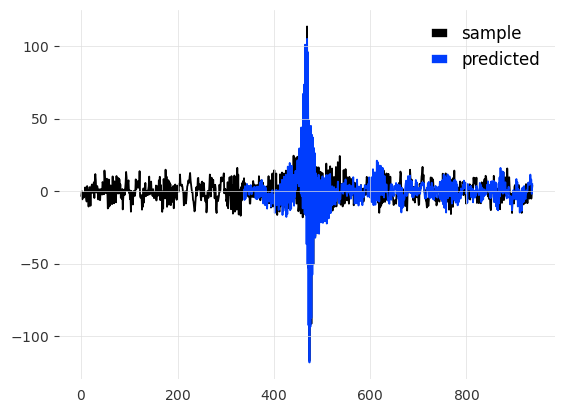

In [19]:
plt.plot(test_series.values(),label='sample')
plt.plot(np.arange(338,938,1),preditiction.values(),label='predicted')
plt.legend()

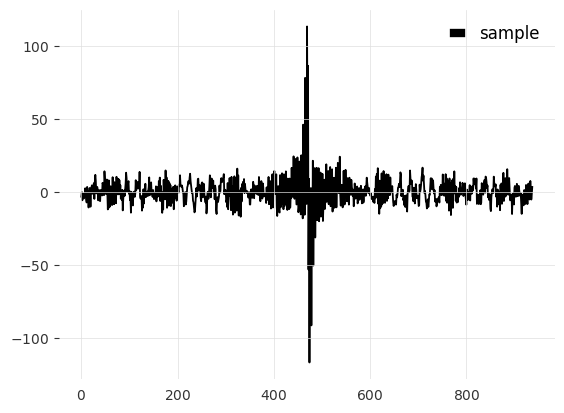

In [20]:
plt.plot(test_series.values(),label='sample')
#plt.plot(np.arange(338,938,1),preditiction.values(),label='predicted')
plt.legend()

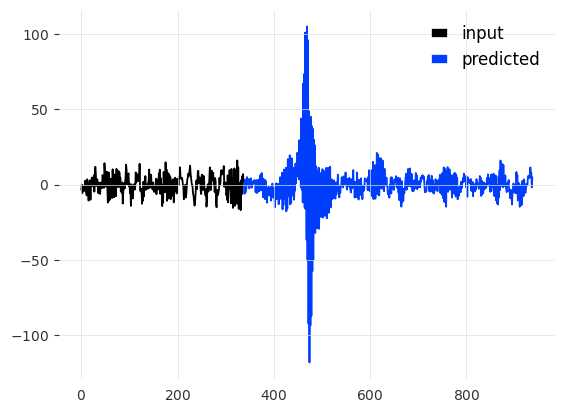

In [21]:
plt.plot(test_series.values()[:338],label='input')
plt.plot(np.arange(338,938,1),preditiction.values(),label='predicted')
plt.legend()

# N-Linear

In [22]:
from darts.models import NLinearModel

In [23]:
model = NLinearModel(

    input_chunk_length=338,

    output_chunk_length=600,

    n_epochs=100000,

)

In [24]:
model.fit(series)

Training: 0it [00:00, ?it/s]

NLinearModel(shared_weights=False, const_init=True, normalize=False, use_static_covariates=True, input_chunk_length=338, output_chunk_length=600, n_epochs=100000)

In [25]:
preditiction=model.predict(600,test_series[:338])

Predicting: 0it [00:00, ?it/s]

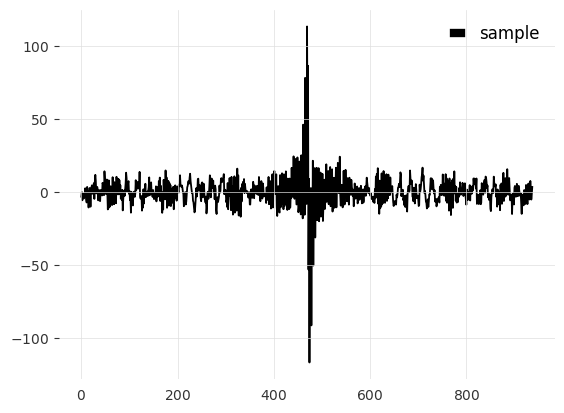

In [26]:
plt.plot(test_series.values(),label='sample')
#plt.plot(np.arange(338,938,1),preditiction.values(),label='predicted')
plt.legend()

In [27]:
preditiction=model.predict(600,test_series[:338])

Predicting: 0it [00:00, ?it/s]

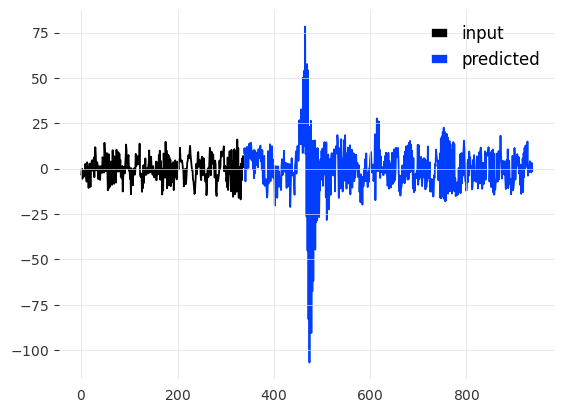

In [28]:
plt.plot(test_series.values()[:338],label='input')
plt.plot(np.arange(338,938,1),preditiction.values(),label='predicted')
plt.legend()

# Transformer

In [29]:
from darts.models import TransformerModel

In [30]:
model = TransformerModel(
    input_chunk_length=338,
    output_chunk_length=600,
    n_epochs=100000,
    pl_trainer_kwargs={
      "accelerator": "gpu",
      "devices": [0]
    },
    d_model=1024,
)

In [31]:
model.fit(series)

Training: 0it [00:00, ?it/s]

TransformerModel(d_model=1024, nhead=4, num_encoder_layers=3, num_decoder_layers=3, dim_feedforward=512, dropout=0.1, activation=relu, norm_type=None, custom_encoder=None, custom_decoder=None, input_chunk_length=338, output_chunk_length=600, n_epochs=100000, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [32]:
preditiction=model.predict(600,test_series[:338])

Predicting: 0it [00:00, ?it/s]

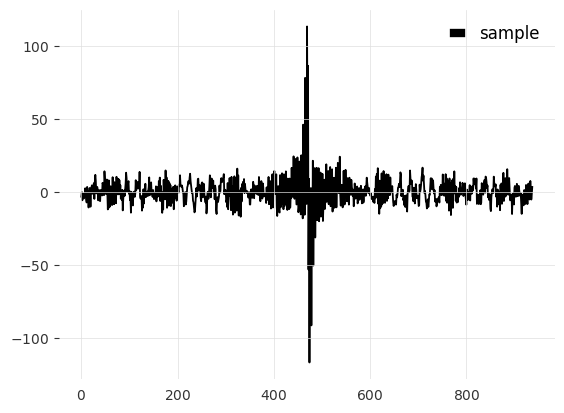

In [33]:
plt.plot(test_series.values(),label='sample')
#plt.plot(np.arange(338,938,1),preditiction.values(),label='predicted')
plt.legend()

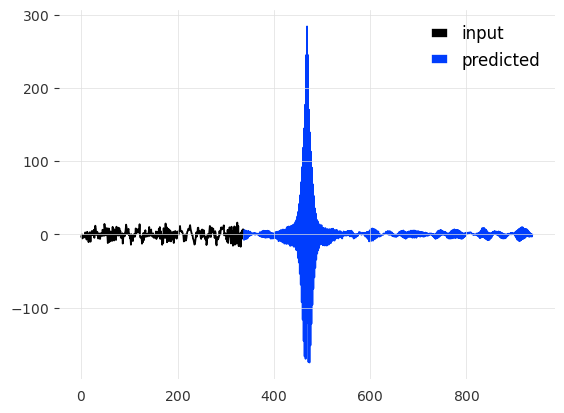

In [34]:
plt.plot(test_series.values()[:338],label='input')
plt.plot(np.arange(338,938,1),preditiction.values(),label='predicted')
plt.legend()